##### Estadisticas generales sobre el covid-19

In [1]:
from utilidades import *

# data, aggregated_mobility, local_mobility = lazy_load_data('santa cruz')
data, aggregated_mobility, local_mobility = lazy_load_data()
x = range(len(data[0]))

##### Casos

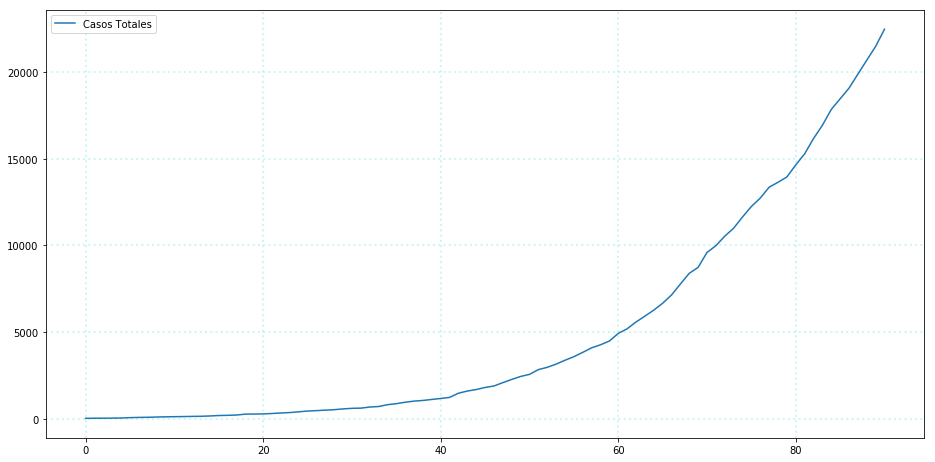

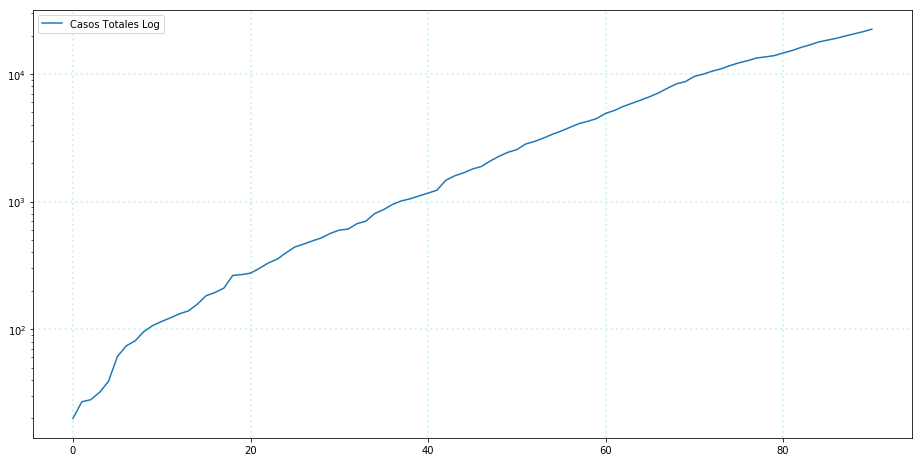

In [2]:
ax = plot(x, data[1], labels=['Casos Totales'])
ax = plot(x, data[1], labels=['Casos Totales Log'])
ax.set_yscale('log')

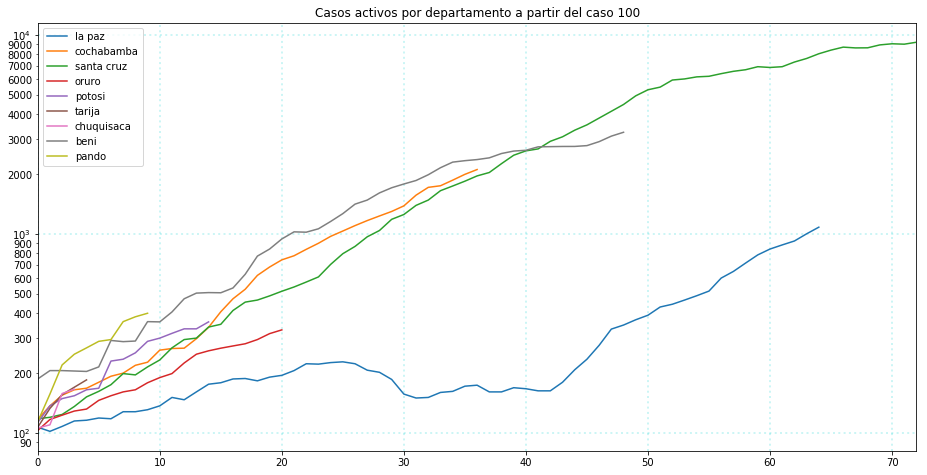

In [3]:
local_data = load_data(aggregate=False)
local_data_index = pd.MultiIndex.from_product(
    [local_data.keys(), ['active_cases', 'cases', 'death', 'recovered', 'tests']]
)

local_data = pd.DataFrame(it.chain(*local_data.values())).T
local_data.columns = local_data_index

def draw_paths(data):
    data = data.dropna(axis=1, how='all').apply(
        lambda _: np.roll(_, -1 * _.first_valid_index())
    , axis=0).dropna(how='all')
    
    if type(data.columns) == pd.MultiIndex:
        data.columns = data.columns.droplevel(1)

    ax = data.plot()
    ax.set_yscale('log')
    ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    pyplot.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    
    return ax

local_active_cases = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'active_cases']]
local_active_cases = local_active_cases[local_active_cases > 100]
ax = draw_paths(local_active_cases)
_ = ax.set_title('Casos activos por departamento a partir del caso 100')

inc avg (15d/5d): 1.18


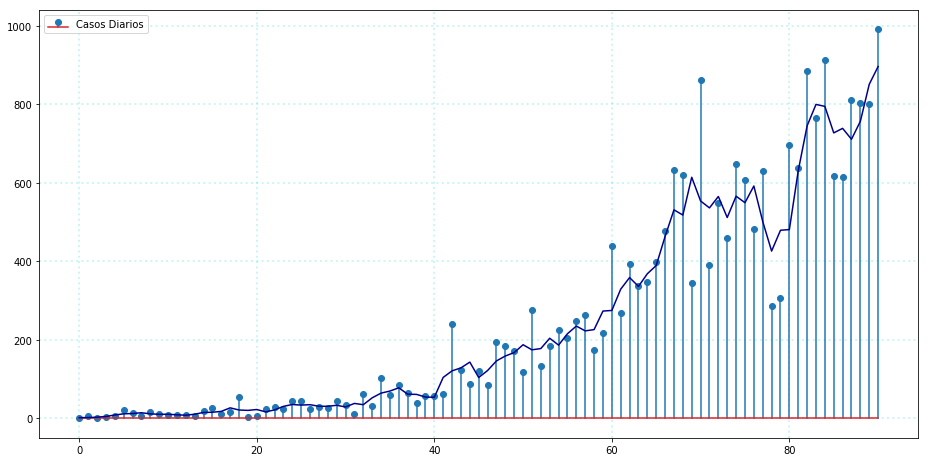

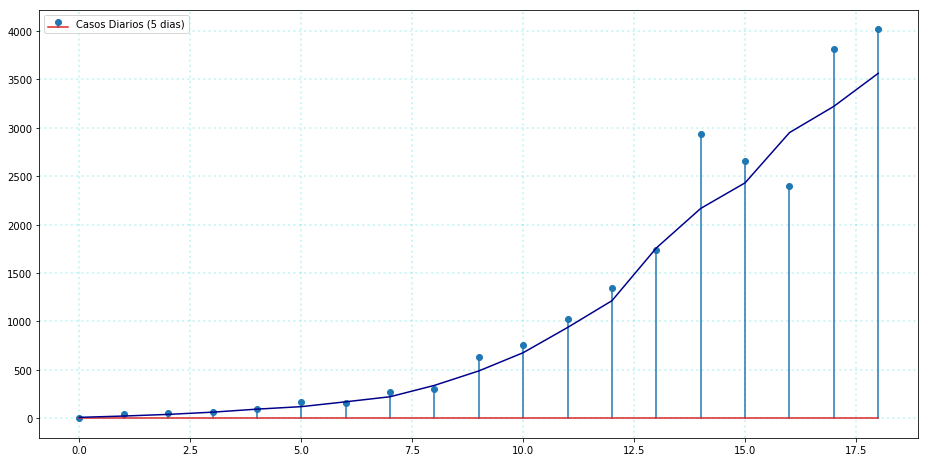

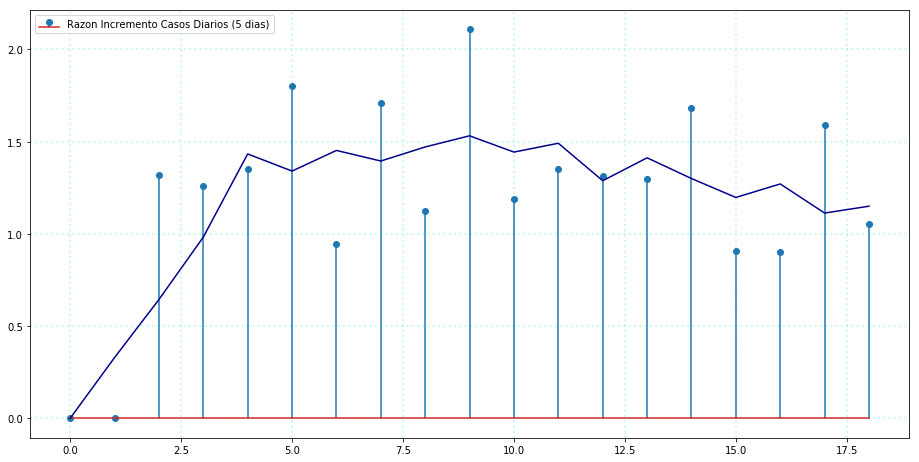

In [4]:
def accumulate(arr, nth = 5):
    pad_arr = np.pad(
        arr, 
        (nth - len(arr) % nth, 0), 
        'constant', 
        constant_values=(0,)
    )
    return np.reshape(pad_arr, (-1, nth)).sum(axis=-1)

new_cases = np.diff(data[1], prepend=[data[1][0]])
plot_moving_averaged(new_cases, label='Casos Diarios')

cum_cases = accumulate(new_cases)
plot_moving_averaged(cum_cases, label='Casos Diarios (5 dias)')

cum_cases[cum_cases < 1.] = 1.
inc_cases = [0] * 2 + [cum_cases[_ + 1] / cum_cases[_] for _ in range(1, len(cum_cases) - 1)]
inc_cases = np.array(inc_cases)
inc_cases[inc_cases > 10.] = 10.
plot_moving_averaged(inc_cases, label='Razon Incremento Casos Diarios (5 dias)')

print('inc avg (15d/5d): {:.2f}'.format(np.mean(inc_cases[-3:])))

###### R_t 

avg Rt m1 (30d): 1.2766229012414843
r_ts[-1]: 1.2170154686078254 +- 0.07832966223399973

avg Rt m2 (30d): 1.1973679271115052
r_ts[-1]: 1.2018830066368265 +- 0.533768461264061


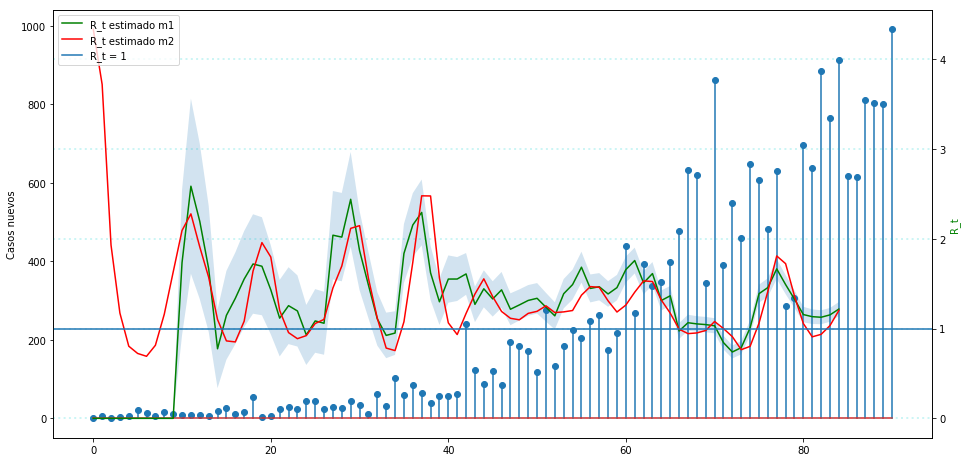

In [5]:
r_ts, r_ts_min, r_ts_max = estimate_rt(new_cases, window_size=3)

fig, ax = pyplot.subplots()
ax.stem(new_cases)
ax.set_ylabel('Casos nuevos')

ax2 = ax.twinx()
ax2.set_ylabel('R_t', color='green')
ax2.plot(r_ts, color='green', label='R_t estimado m1')
ax2.fill_between(
    range(len(r_ts)),
    r_ts_min,
    r_ts_max,
    alpha=0.2
)

print('avg Rt m1 (30d): {}\nr_ts[-1]: {} +- {}'.format(
    np.mean(r_ts[r_ts > 0][-30:]),
    r_ts[-1], r_ts_max[-1] - r_ts[-1]
))


def estimate_rt_2(new_cases, window_size=0):
    rts = []
    if window_size > 0:
        new_cases = moving_average(new_cases, window_size)
                
    for idx in range(7, len(new_cases) + 1):
        rt = sum(new_cases[idx - 3: idx]) / max(1., sum(new_cases[idx - 7:idx - 4]))
        rts.append(rt)
        
    rts = np.array(rts)
    rts[rts > 6.] = 6.
    
    return rts

r_ts_2 = estimate_rt_2(new_cases, window_size=3)
ax2.plot(r_ts_2, color='red', label='R_t estimado m2')
print('\navg Rt m2 (30d): {}\nr_ts[-1]: {} +- {}'.format(
    np.mean(r_ts_2[r_ts_2 > 0][-30:]), 
    r_ts_2[-1], np.std(r_ts_2[-7:]) * 2.
))

ax2.axhline(1., label='R_t = 1')

pyplot.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
_ = ax2.legend(loc='upper left')

Refs   
[1]: https://stochastik-tu-ilmenau.github.io/COVID-19/reports/repronum/repronum.pdf   
[2]: https://biocomsc.upc.edu/en/covid-19/Methods.pdf/view

Tiempo de duplicacion

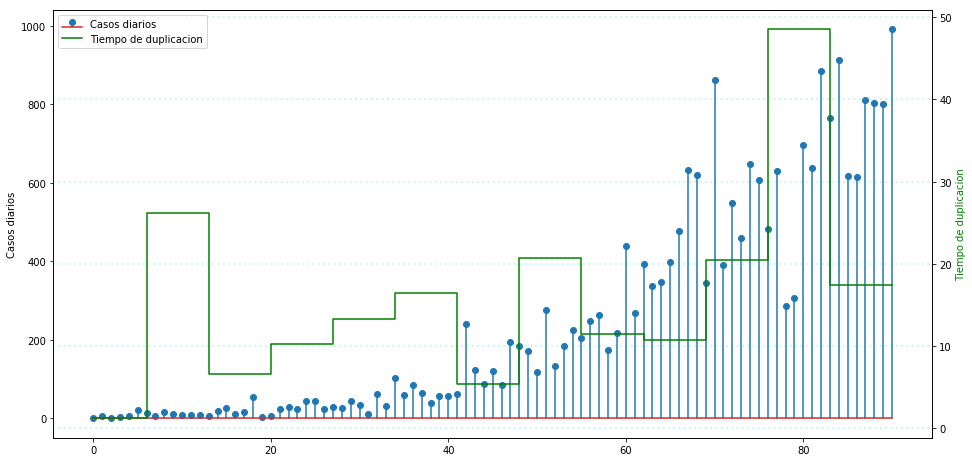

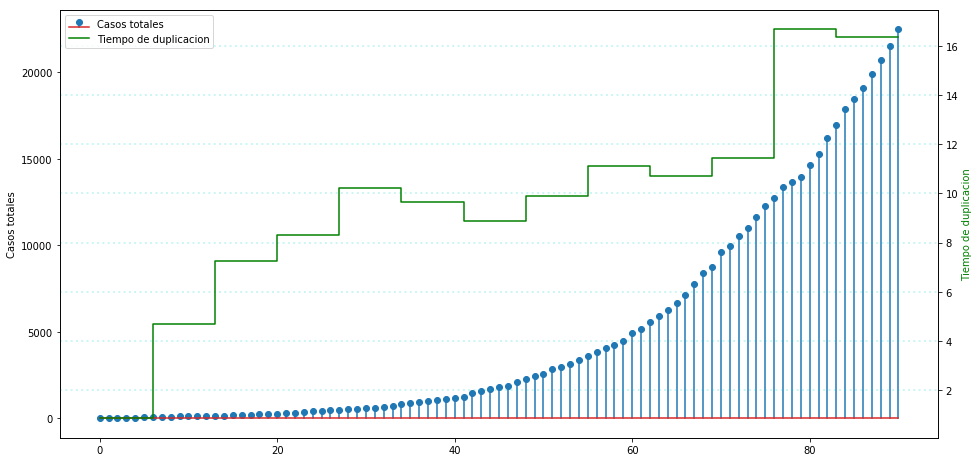

In [6]:
NTH = 7

# razon_incremento^x = 2
def doubling_times(arr):
    dts = [0]
    cum_arr = accumulate(arr, nth=NTH)
    
    for idx in range(1, len(cum_arr)):
        diff = max(
            1, cum_arr[idx] / max(1., cum_arr[idx - 1])
        )
        dts.append(NTH * np.log(2) / max(.1, np.log(diff)))
    
    return dts

def draw_doubling(arr, title=''):
    dts = doubling_times(arr)
    dts = np.repeat(dts, NTH)[-1 * len(arr):]

    fig, ax = pyplot.subplots()
    p1 = ax.stem(arr, label=title)
    ax.set_ylabel(title)

    ax2 = ax.twinx()
    ax2.set_ylabel('Tiempo de duplicacion', color='green')
    p2 = ax2.step(range(len(dts)), dts, color='green', label='Tiempo de duplicacion')

    pyplot.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    fig.legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)
    
draw_doubling(new_cases, title='Casos diarios')
draw_doubling(data[1], title='Casos totales')

###### Movilidad

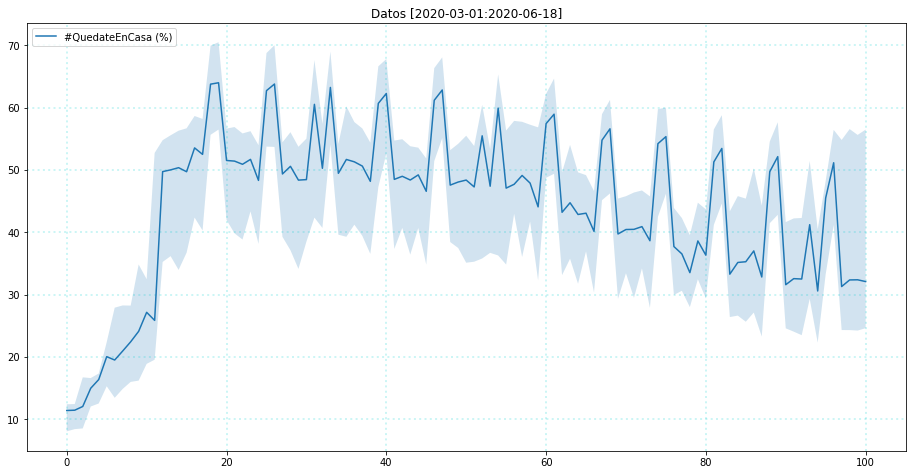

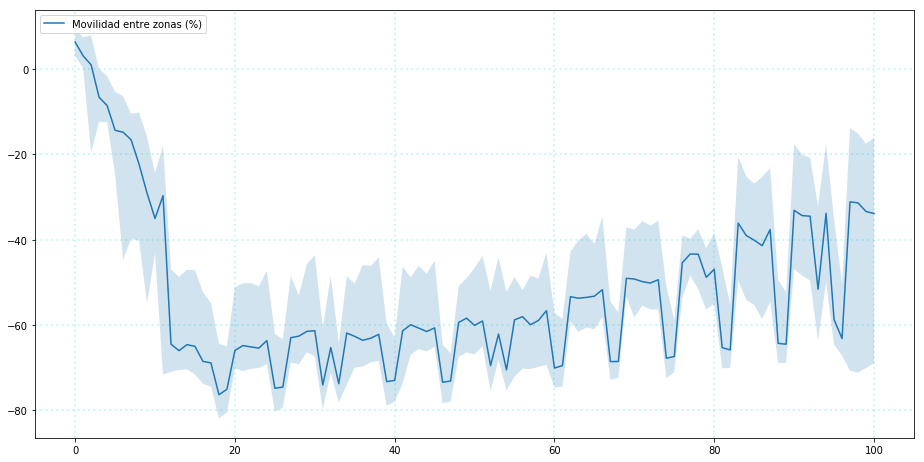

In [7]:
if aggregated_mobility:
    visited_tiles_change, single_tile_ratio = aggregated_mobility
    visited_tiles_change = visited_tiles_change.loc['2020-03-10':]
    single_tile_ratio = single_tile_ratio.loc['2020-03-10':]

    visited_tiles_change_local, single_tile_ratio_local = local_mobility

    ax = plot(range(len(single_tile_ratio)), single_tile_ratio * 100, labels=['#QuedateEnCasa (%)'])
    ax.fill_between(
        range(len(single_tile_ratio)),
        single_tile_ratio_local.loc['2020-03-10':].min(axis=1) * 100,
        single_tile_ratio_local.loc['2020-03-10':].max(axis=1) * 100,
        alpha=0.2
    )
    ax.set_title('Datos [{}:{}]'.format(
        single_tile_ratio_local.iloc[0].name, single_tile_ratio_local.iloc[-1].name
    ))

    ax = plot(range(len(visited_tiles_change)), visited_tiles_change * 100, labels=['Movilidad entre zonas (%)'])
    _ = ax.fill_between(
        range(len(single_tile_ratio)),
        visited_tiles_change_local.loc['2020-03-10':].min(axis=1) * 100,
        visited_tiles_change_local.loc['2020-03-10':].max(axis=1) * 100,
        alpha=0.2
    )

Cambio en el comportamiento respecto a febrero.   
Fuente: https://data.humdata.org/dataset/movement-range-maps   
   
En la <a href='https://research.fb.com/blog/2020/06/protecting-privacy-in-facebook-mobility-data-during-the-covid-19-response/'>metodologia</a> facebook aclara que: `Only people who opt in to Location History and background location collection are included`   


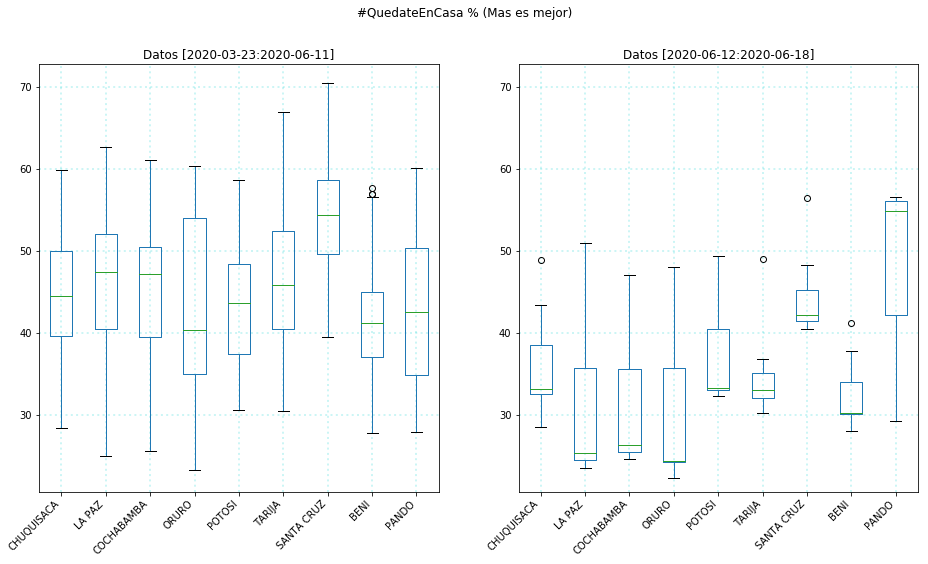

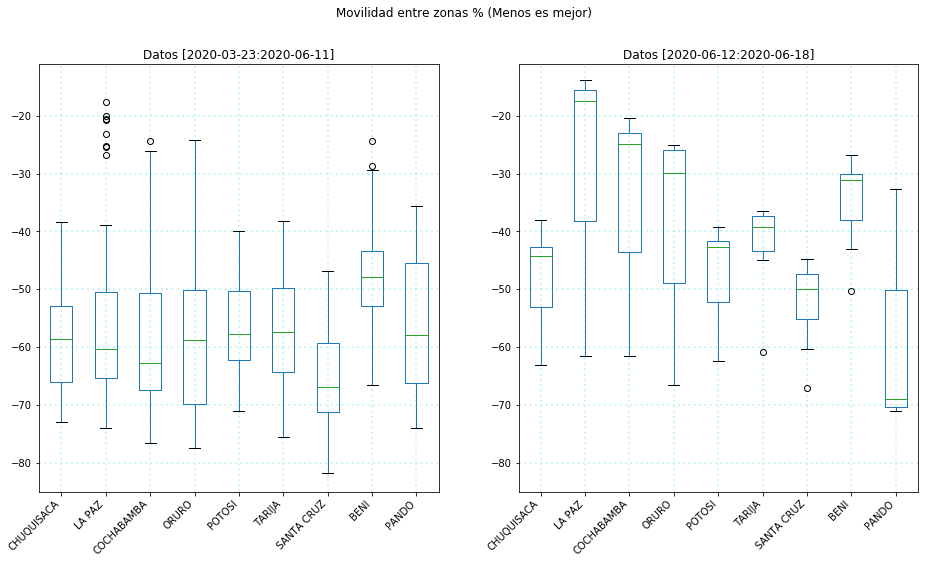

In [8]:
def box_plot_compare(data, title):
    data = data * 100
    
    fig, axs = pyplot.subplots(ncols=2, nrows=1)
    fig.suptitle(title)
    
    data_range = data.loc['2020-03-23':].head(-7)
    data_range.boxplot(ax=axs[0])
    axs[0].set_title('Datos [{}:{}]'.format(
        data_range.iloc[0].name, data_range.iloc[-1].name
    ))
    axs[0].grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')
    
    data_range = data.tail(7)
    data_range.boxplot(ax=axs[1])
    axs[1].set_title('Datos [{}:{}]'.format(
        data_range.iloc[0].name, data_range.iloc[-1].name
    ))
    axs[1].grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')
    
    ymin = min([axs[0].get_ylim()[0], axs[1].get_ylim()[0]])
    ymax = max([axs[0].get_ylim()[1], axs[1].get_ylim()[1]])
    axs[0].set_ylim(ymin, ymax)
    axs[1].set_ylim(ymin, ymax)
    
if local_mobility:
    box_plot_compare(single_tile_ratio_local, title='#QuedateEnCasa % (Mas es mejor)')
    box_plot_compare(visited_tiles_change_local, title='Movilidad entre zonas % (Menos es mejor)')

##### Fallecidos

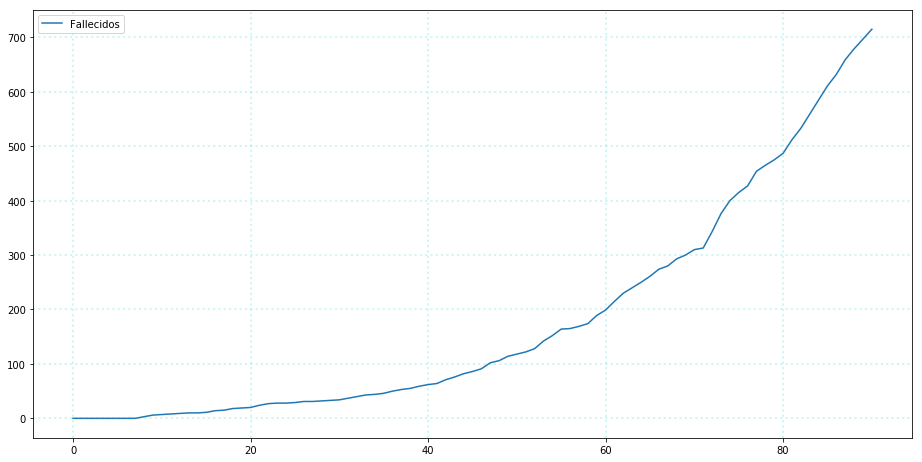

In [9]:
_ = plot(x, data[2], labels=['Fallecidos'])

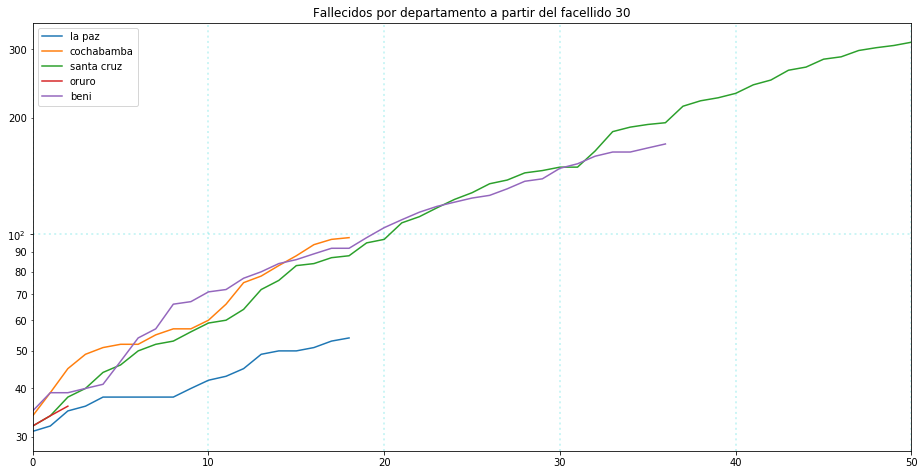

In [10]:
local_deaths = local_data.loc[pd.IndexSlice[:],pd.IndexSlice[:,'death']]
ax = draw_paths(local_deaths[local_deaths > 30])
_ = ax.set_title('Fallecidos por departamento a partir del facellido 30')

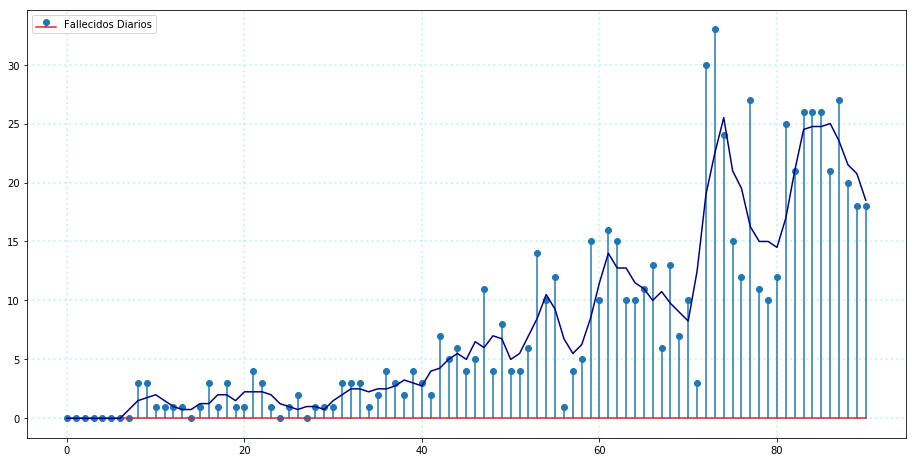

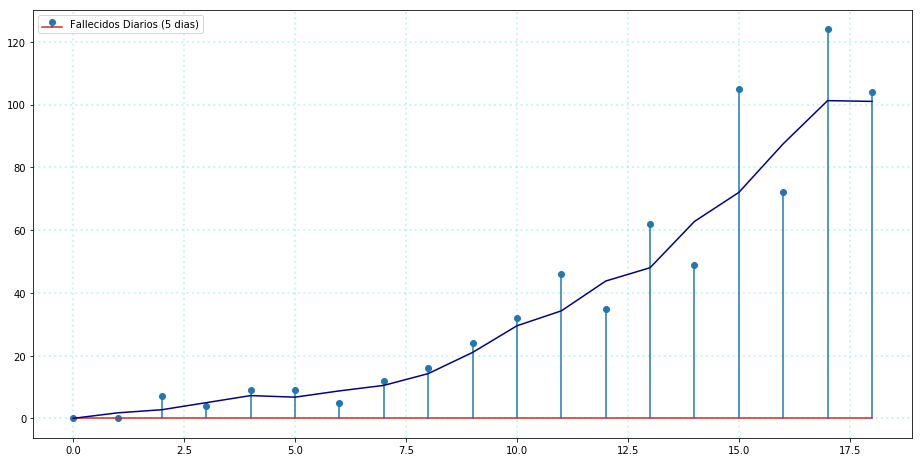

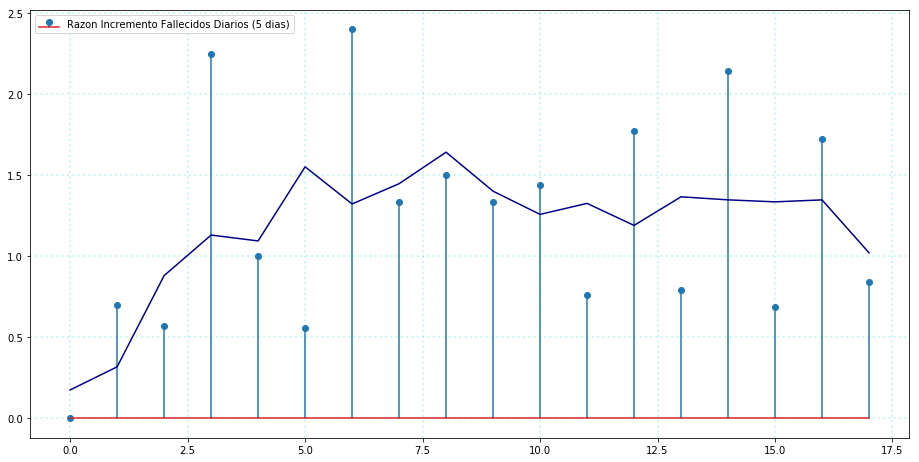

In [11]:
new_deaths = np.diff(data[2], prepend=[data[2][0]])
plot_moving_averaged(new_deaths, label='Fallecidos Diarios')

cum_deaths = accumulate(new_deaths)
plot_moving_averaged(cum_deaths, label='Fallecidos Diarios (5 dias)')

inc_deaths = [cum_deaths[_ + 1] / (cum_deaths[_] or 10.) for _ in range(len(cum_deaths) - 1)]
_ = plot_moving_averaged(inc_deaths, label='Razon Incremento Fallecidos Diarios (5 dias)')

Tiempo de Duplicacion

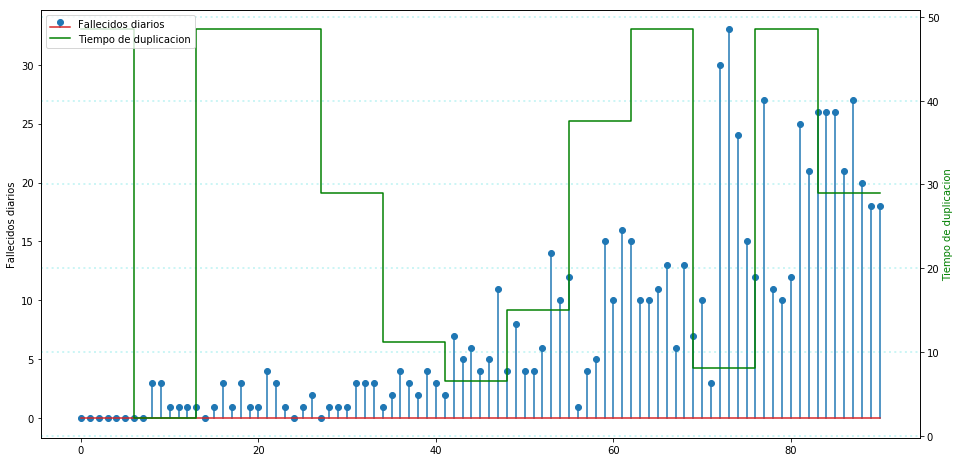

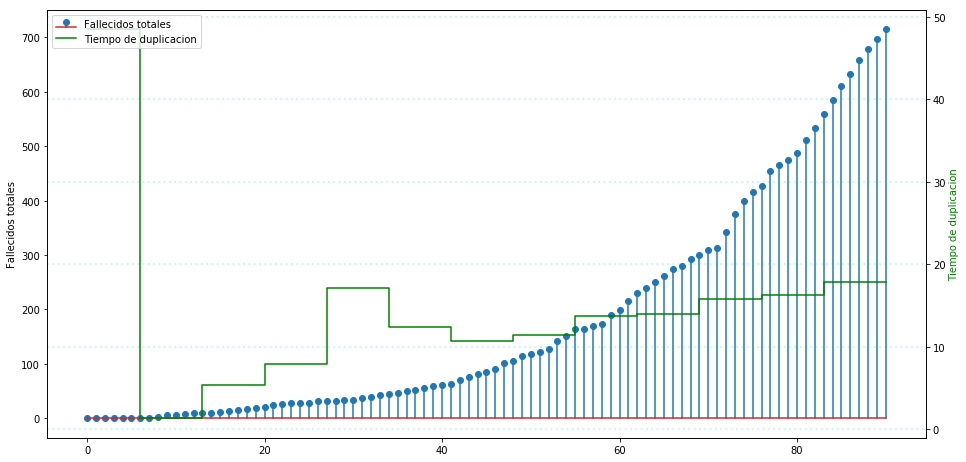

In [12]:
draw_doubling(new_deaths, title='Fallecidos diarios')
draw_doubling(data[2], title='Fallecidos totales')

###### Recuperados 

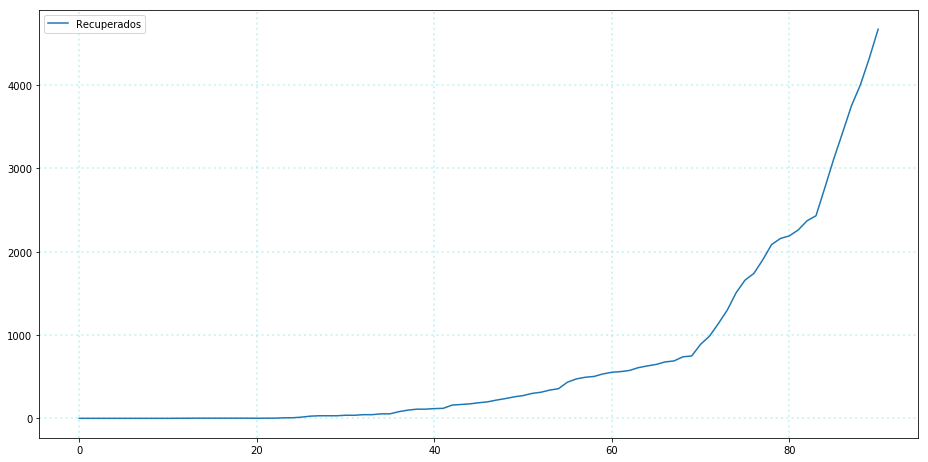

In [13]:
_ = plot(x, data[3], labels=['Recuperados'])

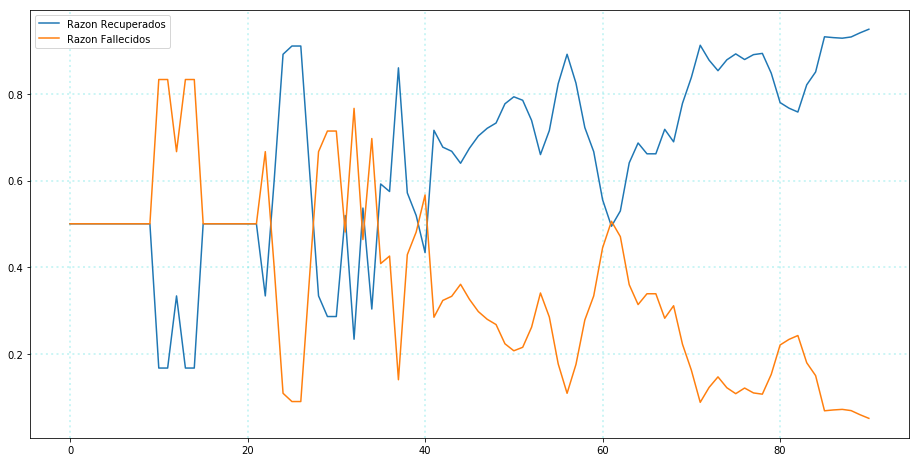

In [14]:
new_recovered = np.diff(data[3], prepend=[data[3][0]])

closed_cases = new_recovered + new_deaths
closed_cases[closed_cases < 1] = 1

recovered_rate = new_recovered / closed_cases
recovered_rate = moving_average(recovered_rate, 3)
recovered_rate[recovered_rate < .001] = .5

_ = plot(
    x, recovered_rate, 1 - recovered_rate,
    labels=['Razon Recuperados', 'Razon Fallecidos']
)

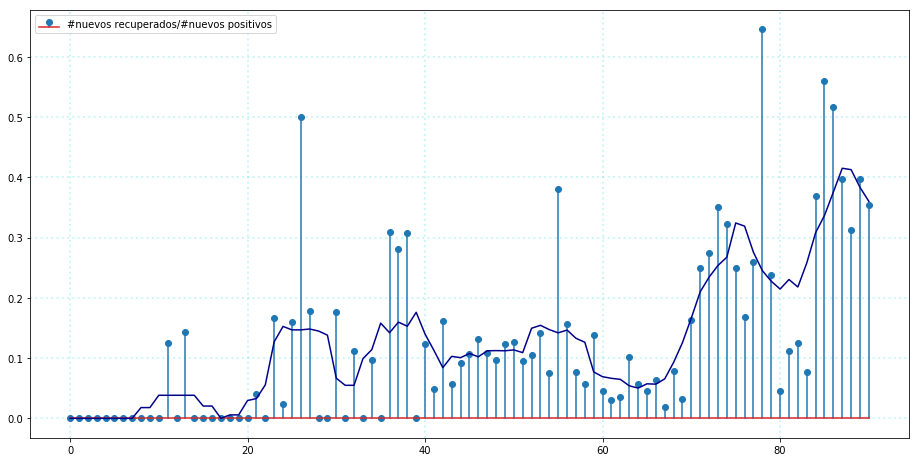

In [15]:
new_cases[new_cases < 1] = 1
recovered_to_new_cases = new_recovered / new_cases
recovered_to_new_cases[recovered_to_new_cases < 0] = 0
recovered_to_new_cases[recovered_to_new_cases > 6] = 6

ax = plot_moving_averaged(
    recovered_to_new_cases,
    label='#nuevos recuperados/#nuevos positivos',
    window_size = 7
)

##### Tests

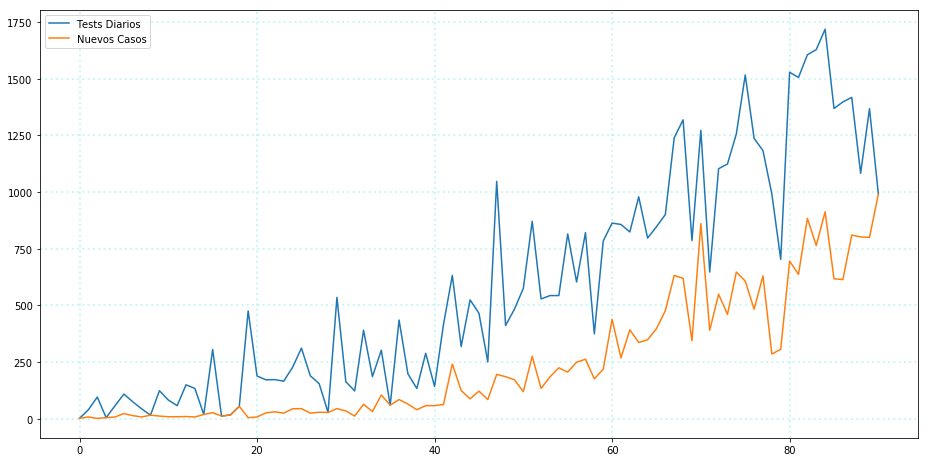

In [16]:
daily_tests = np.diff(data[-1], prepend=[data[-1][0]])
daily_tests[daily_tests < 1] = new_cases[daily_tests < 1]
_ = plot(x, daily_tests, new_cases, labels=['Tests Diarios', 'Nuevos Casos'])

Tests Diarios = <a href='https://github.com/mauforonda/covid19-bolivia/blob/master/descartados.csv'>Descartados</a> + <a href='https://github.com/mauforonda/covid19-bolivia2/blob/master/nacional.csv'>Nuevos Casos</a> + Recuperados   
Como referencia el 04/24, en el <a href='https://www.boliviasegura.gob.bo/comunicados_proc.php?Seleccion=23'>reporte del ministerio</a> indica que '4.490 casos fueron descartados mediante pruebas de laboratorio', misma cantidad que esta en los datos compilados por <a href='https://github.com/mauforonda'>@mauforonda</a>.  
Los datos a partir del 2020-05-02 fueron recogidos y procesados por la revista <a href='https://muywaso.com/especial-de-datos-muy-waso-sobre-el-coronavirus-en-bolivia/'>muywaso.com</a>.

Cuantos tests se necesitan para encontar un caso positivo?

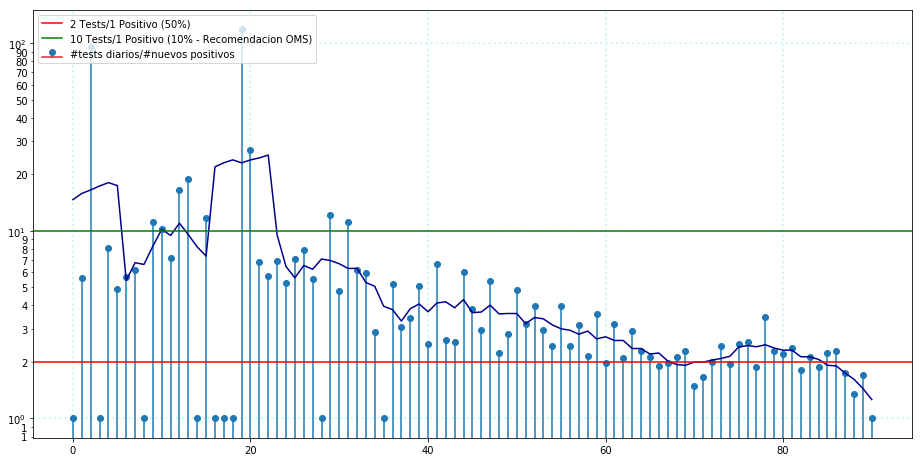

In [17]:
ax = plot_moving_averaged(
    daily_tests / new_cases, 
    label='#tests diarios/#nuevos positivos',
    window_size = 7
)
ax.axhline(2., label='2 Tests/1 Positivo (50%)', color='red')
ax.axhline(10., label='10 Tests/1 Positivo (10% - Recomendacion OMS)', color='green')

ax.set_yscale('log')
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
_ = ax.legend(loc='upper left')

Datos que faltarian:
* Porcentaje de los detectados diarios que son contactos de un infectado ya detectado.
    * Nro de contactos o si fuera posible, distribucion del # de contactos registrados
    * Lugares donde se dan esas transmisiones (hogar, trabajo, reunion, ...) relacionado al # de contactos (buscando clusters)
* Ocupacion de camas hospitales, cuidados intermedios, terapia intensiva, aislados en centros (como en <a href='https://github.com/mauforonda/covid19-lapaz-establecimientos'>La Paz</a>)
* Porcentaje de los fallecidos que no fueron atendidos en hospital o fallecieron a poco de llegar.    
* Historico de fallecimientos estos meses, historico de fallecimientos de otros anhos.